# Part one: Set-up

## #1
### Build training and test dataframe

In [1]:
#1
import pandas as pd
import glob
# build a train dataframe
train_data = []
train_files = glob.glob('/Users/chensong/UW/2020spring/575B/Problem_set/problemset3/train/*.txt')
for f in train_files:
    with open (f, "r") as trainfile:
        train_data.append(trainfile.read())
df_train = pd.DataFrame(train_data, columns=['text'])
# build a test dataframe
test_data = []
test_files = glob.glob('/Users/chensong/UW/2020spring/575B/Problem_set/problemset3/test/*.txt')
for f_test in test_files:
    with open(f_test, "r") as testfile:
        test_data.append(testfile.read())
df_test = pd.DataFrame(test_data, columns=['text'])
# print the shape of train and test dataframe
print(f"The shape of train dataframe is {df_train.shape}")
print(f"The shape of test dataframe is {df_test.shape}")


The shape of train dataframe is (528, 1)
The shape of test dataframe is (111, 1)


## #2
### Create training labels

In [2]:
#2
import numpy as np
#iterate every row and get the first two words as labels
train_labels = []
train_text = []
for index, row in df_train.iterrows():
    split_words = row[0].split(":")
    train_labels.append(split_words[0])
    train_text.append(split_words[1])    
label_vector = np.asarray(train_labels)
# check the length of label_vector
print(len(label_vector))
# delete the label words in the training text
df_training = pd.DataFrame(df_train['text'].apply(lambda row: row.split(":")[1]))
# check the df_training
df_training.head()


528


,text
0,Five million assault weapons are on the stree...
1,So what I am saying is that it seems to me th...
2,Who has spent full time… Who has spent full t...
3,"So let’s be clear, whenever someone hears the..."
4,This morning. I announced this morning that I...


### Compare the file names with the start of the text

In [3]:
#Extract the file names
import os
filenames_list = []
for file in train_files:
    filenames_extension = os.path.splitext(os.path.basename(file))[0]
    filenames_tidy = filenames_extension.split("_")[0]
    filenames_list.append(filenames_tidy)
#Extract the last name of train labels
train_label_last_name = [i.split(' ')[1] for i in train_labels]
# find the difference
differences = set(filenames_list) - set(train_label_last_name)
print(differences)
len(differences)

set()


0

#### From the differences results, we can see that there no unmatched names.

### Distribution of labels

Text(0, 0.5, 'Counts of labels')

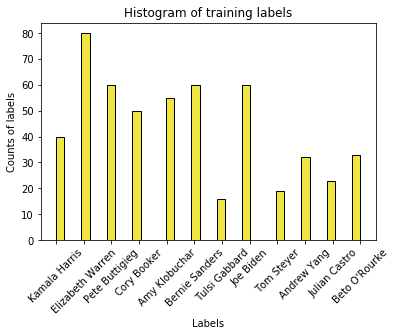

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(label_vector, color = '#F0E442', edgecolor = 'black',
         bins = int(180/5))
plt.xticks(rotation=45)
# Add labels
plt.title('Histogram of training labels')
plt.xlabel('Labels')
plt.ylabel('Counts of labels')


##### From the plot, we can see that Elizabeth Warren label has the most frequency, and the Tulsi Gabbard has the least frequency. The most
##### frequency is 80 and the lowest frequency is near 20. What's more, most of the counts are between 40 times to 60 times.

## #3
### Deal with the text in the training data

In [5]:
from nltk.corpus import stopwords
# Convert to lower case
df_training = df_training.apply(lambda x: x.astype(str).str.lower())
# Romove punctuation
df_training = df_training.apply(lambda x: x.astype(str).str.replace('[^\w\s]',' '))
# split the sentence to words
df_tokens = df_training.apply(lambda x : x.astype(str).str.split() )
# Romove stopwords
stop_words = stopwords.words('english')
df_token_nsw = pd.DataFrame(df_tokens['text'].apply(lambda x: [item for item in x if item not in stop_words]))



##### Roughly looking through the token words after filtered out the stop words in the NLTK package, I find that some verb words such as think, tell, go, see are visible frequently in the whole data, and modal verbs such as will, can, get are pretty frequent too. However, these words help little in analyzing the topic types because the whold data is about people's opinions on the election. So the word "think", "see", "go" has nothing to do with the election/politics but a way people using to express the sentence. What's more, there are some numbers that are splited by the space such as '000', '10', '05' are also not helpful to address the topic identification.So the first step I am doing here is to delete these "useless words" according to the first glance and common sense. Next, I think a word clouds can help me further filter the stop word. I think it is helpful because from the word clouds I can get the most frequent words, then I can analyze whether these most fequent words are helpful to the topics.

### Word cloud

In [6]:
# make a word cloud list
cloud_list = []
for index, row in df_token_nsw.iterrows():
    for word in row[0]:
        cloud_list.append(word)
# join every word in the list
comment = " ".join(w for w in cloud_list)
           

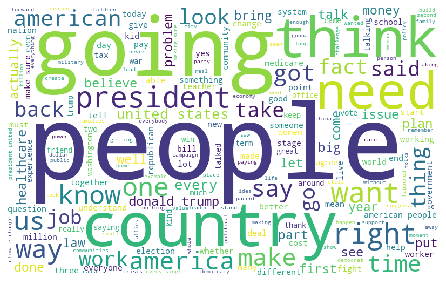

In [7]:
from wordcloud import WordCloud
# create a word cloud
wordcloud_comment = WordCloud(width = 800, height = 500, 
                background_color ='white',  
                min_font_size = 10).generate(comment) 
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud_comment) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

##### From the word cloud, we can definitely further filter the stop words. We can go with the most noticable words which show most  frequently but not useful for the topic recognize in our case. In my opinion, words such as "people", "country", "america", "president", "healthcare", "right", "job" are significant in our case because these words are the main words in politics, so these words should be kept. However, words such as "us", "going", "one", "say", " said" , " think", "take", " every" , "thing" , "see", "let" are useless to define the topic as I mentioned when I did the first glance at the whole data. So I will consider these words as specific stop words in this case and I will remove them.

### Remove the specific stopwords

In [8]:
# build a specific stop words list
specific_stopwords = ['going', 'go', 'think', 'one', 'need', 'us', 'got', 'say', 'saying', 'want', 'every', 'make',
                     'let', 'see', 'must', 'made', 'take', 'taking', 'someone', '000','02', '040','05','10', '100',
                     '1000','people']
# remove the specific stop words in the training data
df_token_nsw = pd.DataFrame(df_tokens['text'].apply(lambda x: [item for item in x if ((item not in stop_words) & (item not in specific_stopwords))]))
df_training = df_token_nsw['text'].apply(lambda x: " ".join (word for word in x))

## #4
### Stem/lemmatize the data

In [9]:
# stemmer
from nltk.stem import PorterStemmer
stemmerport = PorterStemmer()
df_training_stem = df_training.apply(lambda x: ' '.join([stemmerport.stem(word) for word in x.split()]))

In [10]:
print(df_training_stem[6])
print(df_training_stem[500])

problem poll problem polici lesson courag polit person everyon stage determin get someth done everyon stage recogn least thought problem democrat agre particular idea handl problem nation rifl associ enabl congress unit fight
issu think dad tonight sit kitchen tabl everyon gone sleep sit cup tea coffe tri figur work probabl sit decid minimum wage job pay enough meet bill end month start drive uber mean mean two job miss kid soccer game realiti american today ye pass get elect pass bill give american famili make less year tax credit 6 year home 500 month real differ man life tell big deal tri get end month


In [11]:
print(df_training[6])
print(df_training[500])

problem polls problem policy lessons courage political personal everyone stage determined get something done everyone stage recognizes least thought problem democrats agree particular idea handle problem national rifle association enablers congress united fight
issue thinking dad tonight sitting kitchen table everyone gone sleep sitting cup tea coffee trying figure work probably sitting deciding minimum wage job pay enough meet bills end month start driving uber mean means two jobs miss kids soccer games reality americans today yes pass get elected pass bill give american family makes less year tax credit 6 year home 500 month real difference man life tell big deal trying get end month


##### From the results above , we can see that after stemmering, the affix is removed. The stemmer remove the affix of pural words, past-tense word and "-ing" form. So compared the results, it is noticable that the words ending with "e", "ed", "s", "ing", "y" are changed by removing these affix. The root word is kept.

In [12]:
# lemmatizer
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
df_training_lemmatizer = df_training.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [13]:

print(df_training_lemmatizer[6])
print(df_training_lemmatizer[500])

problem poll problem policy lesson courage political personal everyone stage determined get something done everyone stage recognizes least thought problem democrat agree particular idea handle problem national rifle association enablers congress united fight
issue thinking dad tonight sitting kitchen table everyone gone sleep sitting cup tea coffee trying figure work probably sitting deciding minimum wage job pay enough meet bill end month start driving uber mean mean two job miss kid soccer game reality american today yes pas get elected pas bill give american family make le year tax credit 6 year home 500 month real difference man life tell big deal trying get end month




##### From the results, we can see the difference between stemmer and lemmatizer in NLTK. Stemmer just cut the end or the beginning of the word regradless of the morphology of the word. However, Lemmatizer works with consideration of the morphology of the words. So that's why after stemmering, we can see that some words are wrong, such as "determin", realiti". But the words after lemmatizering are right spelled.

## #5
### Tokenize training data using unigrams

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(df_training_lemmatizer)
counts_training = vectorizer.transform(df_training_lemmatizer)
counts_training = counts_training.toarray()
counts_training.shape

(528, 4228)

In [15]:
# check the length of feature names 
len(vectorizer.get_feature_names())

4228

In [16]:
# convert counts to a data frame
counts_training = pd.DataFrame(counts_training, columns = vectorizer.get_feature_names())
counts_training.head()

,10th,11,12,12th,13,130,14,140,149,15,...,yesterday,yet,yogi,york,young,younger,zealand,zelensky,zero,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Set the lower and upper limits

In [17]:
# remove terms that appear too infrequently
# ignore terms that appear in less than 1% of the documents
vec_upper = CountVectorizer(min_df = 0.01)
vec_upper.fit(df_training_lemmatizer)
counts_upper = vec_upper.transform(df_training_lemmatizer)
counts_upper = counts_upper.toarray()
counts_upper.shape

(528, 873)

In [18]:
# remove terms that appear too frequently
# ignore terms that appear in more than 20% documents
vec_lower = CountVectorizer(max_df = 0.2)
vec_lower.fit(df_training_lemmatizer)
counts_lower = vec_lower.transform(df_training_lemmatizer)
counts_lower = counts_lower.toarray()
counts_lower.shape

(528, 4217)

##### From the results above, we can see that when I didn't set the upper and lower limits on frequency, I got 4229 unique tokens in my vocabulary. After I remove the terms that appear in less than 1% of the documents, which means vocabularies that show too infrequently, I got 874 unique words. And after I remove the words that show in more than 20% documents(too frequently), I got 4217 unique words. Since 4217 and 4229 are pretty close, so I think it shows that most of the words in my vocabulary don't appear too frequently, and most of the words are unique words.

## #6
### Process the test data

In [19]:
# set same dimensions for training and test data
counts_test = vectorizer.transform(df_test['text'])
counts_test = counts_test.toarray()
counts_test = pd.DataFrame(counts_test, columns = vectorizer.get_feature_names())

In [20]:
# check dimensions of training data
print(counts_training.shape)
# check dimensions of test data
print(counts_test.shape)

(528, 4228)
(111, 4228)


# Part two: Supervised Learning

## #7
### Add new features


#### Add TF-IDF

In [21]:
# Add feature TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvec = TfidfVectorizer()
tfidfvec.fit(df_training_lemmatizer)
tfidf_training = tfidfvec.transform(df_training_lemmatizer)

# convert to a dataframe
tfidf_training = pd.DataFrame(tfidf_training.toarray(), columns = tfidfvec.get_feature_names())


In [22]:
# Check the shape of tfidf_training
tfidf_training.shape

(528, 4228)

In [23]:
# test data
tfidf_test = tfidfvec.transform(df_test['text'])
# convert to a dataframe
tfidf_test = pd.DataFrame(tfidf_test.toarray(), columns = tfidfvec.get_feature_names())


In [24]:
# Check the shape of tfidf_test
tfidf_test.shape

(111, 4228)

#### Add Sentiment Score

In [25]:
from textblob import TextBlob
def sentimentscore(x):
    return TextBlob(x).sentiment   
# sentiment score on training data 
df_senti_training = pd.DataFrame([sentimentscore(x) for x in df_training_lemmatizer])
# sentiment score on test data
df_senti_test = pd.DataFrame([sentimentscore(x) for x in df_test['text']])


In [26]:
# check dimension of setiment training
print(df_senti_training.shape)
# check dimension of setiment test
print(df_senti_test.shape)

(528, 2)
(111, 2)


#### Add bigram features

In [27]:
# Getting bigrams on training
vectorizer_bi_training = CountVectorizer(ngram_range =(2, 2)) 
X1 = vectorizer_bi_training.fit_transform(df_training_lemmatizer)  
features = (vectorizer_bi_training.get_feature_names()) 
bi_training = pd.DataFrame(X1.toarray(), columns = features)
# check dimension of training
bi_training.shape

(528, 21315)

In [28]:
# Getting bigrams on test
bi_test = vectorizer_bi_training.transform(df_test['text'])
bi_test = bi_test.toarray()
bi_test = pd.DataFrame(bi_test, columns = vectorizer_bi_training.get_feature_names())
# check dimension of test
bi_test.shape

(111, 21315)

#### Add topic model weights

In [29]:
# data prepare for topic model
training_lemmatizer = pd.DataFrame(df_training_lemmatizer, columns = ['text'])
token_lemm = pd.DataFrame(training_lemmatizer.apply(lambda x: [item.split(" ") for item in x]))
token_list = []
t = token_lemm.apply(lambda x: [token_list.append(word)for word in x])
token_list = token_lemm['text'].to_list()

In [30]:
import gensim
from gensim import corpora

# Create Dictionary
dictionary = corpora.Dictionary(token_list)
# Create Corpus
texts = token_lemm
# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in token_list]

In [31]:
len(corpus)

528

In [32]:
# get a overview of topic
np.random.seed(112)
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 8, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.015*"school" + 0.012*"country" + 0.012*"teacher" + 0.009*"president" + 0.007*"would"')
(1, '0.012*"country" + 0.011*"president" + 0.007*"woman" + 0.007*"american" + 0.007*"year"')
(2, '0.010*"country" + 0.010*"right" + 0.009*"president" + 0.007*"job" + 0.007*"america"')
(3, '0.008*"president" + 0.008*"american" + 0.008*"state" + 0.007*"woman" + 0.007*"right"')
(4, '0.013*"american" + 0.011*"president" + 0.009*"right" + 0.008*"way" + 0.007*"country"')
(5, '0.012*"american" + 0.008*"president" + 0.008*"right" + 0.007*"get" + 0.007*"like"')
(6, '0.016*"get" + 0.009*"done" + 0.008*"company" + 0.007*"right" + 0.007*"insurance"')
(7, '0.010*"country" + 0.008*"would" + 0.007*"get" + 0.007*"president" + 0.007*"time"')


#### Apply LDA on training data and test data

In [33]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
# LDA on traning data
lda = LDA(n_components = 8)
lda.fit(counts_training)
ldaOut_training = lda.transform(counts_training)
# convert to a data frame
df_lda_training = pd.DataFrame(ldaOut_training)
# check dimension of ldaOut training
df_lda_training.shape


(528, 8)

In [34]:
# LDA on test data
ldaOut_test = lda.transform(counts_test)
# convert to a data frame
df_lda_test = pd.DataFrame(ldaOut_test)

In [35]:
# check dimension of ldaOut test
df_lda_test.shape

(111, 8)

In [36]:
def convert_lda_features(lda_features, n_topics=8):
    converted_features = []
    for row in lda_features:
        row_converted_features = [0.0] * n_topics
        for lda_tuple in row:
            idx, lda_value = lda_tuple
            row_converted_features[idx] = lda_value
        converted_features.append(row_converted_features)
    return converted_features

#### combine all features to one training dataset

In [37]:
# df_token_nsw, counts_training, tfidf_training, df_senti_training, bi_training, df_lda_training
full_training = pd.concat([df_token_nsw, counts_training, tfidf_training,
                           df_senti_training,bi_training,df_lda_training], 
                          axis=1, sort=False)
# add labels to full_training
full_training['labels'] = train_label_last_name
# check dimension of full_training
full_training.shape

(528, 29783)

In [38]:
#df_token_nswtest, counts_test, tfidf_test, df_senti_test, bi_test, df_lda_test
df_token_test = df_test.apply(lambda x : x.astype(str).str.split())
df_token_nswtest = pd.DataFrame(df_token_test['text'].apply(lambda x: [item for item in x if ((item not in stop_words) & (item not in specific_stopwords))]))


In [39]:
full_test = pd.concat([df_token_nswtest, counts_test, tfidf_test,
                           df_senti_test,bi_test,df_lda_test], 
                          axis=1, sort=False)
# check dimension of full_test
full_test.shape


(111, 29782)

##### We can see that the dimension of full_training and full_test are right, the numbers of rows are the same with the original dataset, and the numbers of columns are the sum of the columns of all the features I added in the previous step.
##### In this problem, I add TF-IDF, sentiment score, bigram, topic weights in my data. Because I think my model ultimately will be used to predict who said what, I need to know how relevant a word is to a document in a collection of documents, what the overall attitude of this person's to this event and what topic does he/she like to talk about. All these information are very helpful to know who said what, and these information can be captured by TF-IDF, sentiment score, and topic weights. The reason why I include bigram is because I notice that when I do the token, some words are splited to an unwanted way, for example, 911 are splited to 9 and 11, so I think bigram can fix this problem, and that's why I include bigram too.


## #8
### Logisitic regression model

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# split training data into training and validation
from sklearn.model_selection import train_test_split
X = full_training.drop(['labels', 'text'], axis=1)
X_train, X_valid, y_train, y_valid= train_test_split(
    X, train_label_last_name, test_size=0.3, random_state=0)



In [41]:
# Create a scaler object
sc = StandardScaler()
# Fit the scaler to the training data and transform
X_train_std = sc.fit_transform(X_train)
# Apply the scaler to the test data
X_valid_std = sc.transform(X_valid)
C = [0.05, 1, 10, 50, 640]
for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    clf.fit(X_train, y_train)
    print('C:', c)
    print('Training accuracy:', clf.score(X_train_std, y_train))
    print('Validation accuracy:', clf.score(X_valid_std, y_valid))


C: 0.05
Training accuracy: 0.21138211382113822
Validation accuracy: 0.20125786163522014
C: 1
Training accuracy: 0.959349593495935
Validation accuracy: 0.41509433962264153
C: 10
Training accuracy: 0.983739837398374
Validation accuracy: 0.4025157232704403
C: 50
Training accuracy: 0.991869918699187
Validation accuracy: 0.4591194968553459
C: 640
Training accuracy: 1.0
Validation accuracy: 0.4591194968553459


##### I set the coefficient as 0.05, 1.5, 10 , 50 and  640 separately to see how does the accurary show. When c = 0.05, the performance of the model is very bad on both training data and validation data. When c increases, the performan of model increases. However, it is noticable that all the models have a very high accurary on the training data,  but the accurary of the validation data is pretty low. When C = 640, the accurary of the valid data approaches 50%, but the accurary of the training data approaches 100%.I think it is because I have too many features in my data, and the features are way more than the observations I have in the data. Plus, I used a lot of transformers in the previous steps. All these can cause overfitting, and overfitting makes my model does a good job on training data but has a very low performance on the validation data.


### Plot the results

In [42]:
def unique(list): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    # print list 
    for x in unique_list: 
        return unique_list

In [43]:
# get classification labels
unique_label = unique(train_label_last_name)

[[44.44 33.33  0.    0.    0.    0.    0.   11.11  0.    0.    0.   11.11]
 [ 3.85 65.38 11.54  7.69  0.    3.85  0.    3.85  0.    0.    0.    3.85]
 [ 0.   13.33 53.33 13.33  6.67  6.67  0.    6.67  0.    0.    0.    0.  ]
 [11.11 11.11 11.11 44.44  5.56 11.11  0.    0.    0.    5.56  0.    0.  ]
 [ 7.14  0.    0.   21.43 64.29  0.    0.    0.    7.14  0.    0.    0.  ]
 [ 5.88 17.65  0.    5.88  5.88 52.94  0.    5.88  0.    5.88  0.    0.  ]
 [ 0.   50.    0.   50.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   14.29  0.    4.76  0.    9.52  0.   61.9   0.    4.76  0.    4.76]
 [ 0.    0.   50.    0.    0.    0.    0.    0.   50.    0.    0.    0.  ]
 [ 0.    6.67 13.33  6.67 13.33 13.33  0.   13.33  0.   26.67  6.67  0.  ]
 [ 0.    0.   33.33 16.67 16.67  0.    0.    0.    0.   16.67 16.67  0.  ]
 [ 0.    8.33 33.33  0.    0.   16.67  0.    8.33  0.    0.    0.   33.33]]


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 <a list of 12 Text yticklabel objects>)

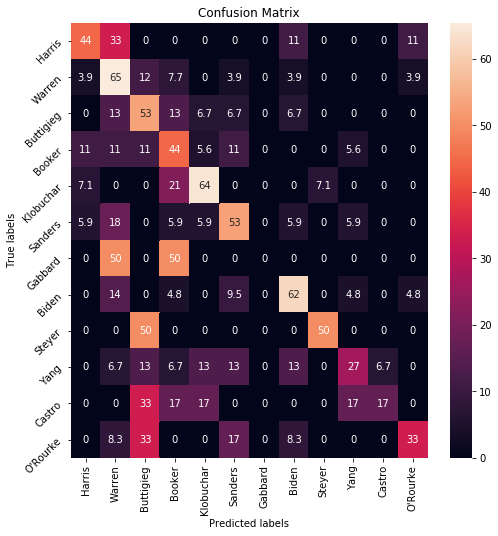

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
clf_logistic = LogisticRegression(penalty='l1', C=50, solver='liblinear')
clf_logistic.fit(X_train, y_train)
y_pred_losgistic = clf_logistic.predict(X_valid)
cm = np.round(confusion_matrix(y_valid, y_pred_losgistic,unique_label, normalize='true'), 4) * 100
print(cm)
fig, ax = plt.subplots(figsize=(8, 8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, ); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(unique_label)
ax.yaxis.set_ticklabels(unique_label)
plt.xticks(rotation=90)
plt.yticks(rotation=45)

##### From the plot, we can see that the model performs particularly well on the "Warren" class, the true positive is 73%, but the model performs particularly poorly on "Gabbard" class. From the head plot, if we look at the the row of Gabbard true labels, we can find that Gabbard are confused to "Warren" and "Booker". I think it may because there are some similar words in "Gabbard", "Warren" and "Booker", or it may because when I split the training and valid dataset, all the data in "Gabbard" class were splitted into valid data, so the machine didn't learn from Gabbard class.

In [45]:
# Apply C = 50 on test data
# prepare data
X_test = full_test.drop(['text'],axis=1) 
X_train_all = full_training.drop(['labels', 'text'],axis=1)
y_train_all = full_training[['labels']]


In [46]:
X_train_std_all = sc.fit_transform(X_train_all)
X_test_pred_std = sc.transform(X_test)
# Apply the scaler to the test data
X_test_std = sc.transform(X_test)
clf_l = LogisticRegression(penalty='l1', C=50, solver='liblinear')
clf_l.fit(X_train_all, y_train_all)
y_test_pred_l = clf_l.predict(X_test)
print('C:', 50)
print('Training accuracy:', clf.score(X_train_std_all, y_train_all))


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


C: 50
Training accuracy: 0.8522727272727273


##### After compared the accuracy of different C values on training and validation data, I chose C = 50 as a final parameter in my model. And the training accurary is 85.23%, test accurary is 43.24%.

## #9
### Build a tree model

In [47]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [48]:
# Apply model on the training data and do validation on the valid data
D = [6,15,20,50,100]
for d in D:
    clf_tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=d)
    clf_tree = clf_tree.fit(X_train,y_train)
    print('Depth:', d)
    print('Training accuracy:', clf_tree.score(X_train, y_train))
    print('Validation accuracy:', clf_tree.score(X_valid, y_valid))

Depth: 6
Training accuracy: 0.3224932249322493
Validation accuracy: 0.13836477987421383
Depth: 15
Training accuracy: 0.5772357723577236
Validation accuracy: 0.1949685534591195
Depth: 20
Training accuracy: 0.6964769647696477
Validation accuracy: 0.23270440251572327
Depth: 50
Training accuracy: 1.0
Validation accuracy: 0.25157232704402516
Depth: 100
Training accuracy: 1.0
Validation accuracy: 0.24528301886792453


#### Plot the results

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 <a list of 12 Text yticklabel objects>)

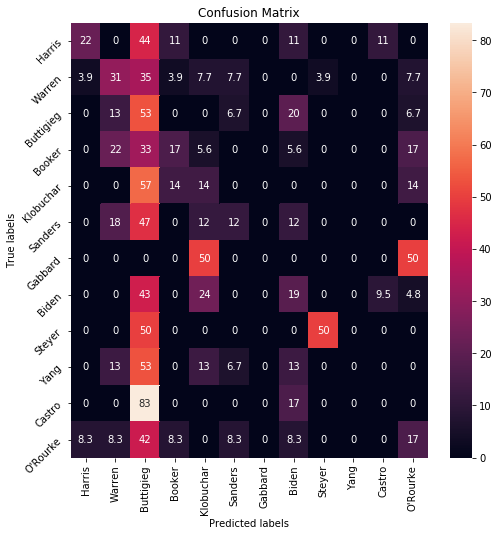

In [49]:
np.random.seed(222)
clf_tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=20)
clf_tree = clf_tree.fit(X_train,y_train)
y_valid_tree = clf_tree.predict(X_valid)
cm = np.round(confusion_matrix(y_valid, y_valid_tree,unique_label, normalize='true'), 4) * 100
fig, ax = plt.subplots(figsize=(8, 8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, ); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(unique_label)
ax.yaxis.set_ticklabels(unique_label)
plt.xticks(rotation=90)
plt.yticks(rotation=45)

###### From the accurary score, we can see that the tree model has lower permance overall than the logistic model, and when max_depth reaches 60, the model becomes overfitting on the training data with accurary 1, however, the accurary of the valid data is pretty low.
##### From the heat plot , we can see that the model performs particularly well on the "Buttigieg" class, the true positive is 53%, but the model performs particularly poorly on "Gabbard" class ,"Yang" class and "Castro" class. They are all misclassified.
##### Since the model with max_depth 20 and the model with max_depth 20 has the same performance on the valid data, but when I set max_depth 50, the model is overfitting, I chose the second model which max_depth is 20 as my model.

In [50]:
# Apply max_depth = 20 on test data

clf_t = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=20)
clf_t = clf_t.fit(X_train_all,y_train_all)
y_test_pred_t = clf_t.predict(X_test)
print('Depth:', 20)
print('Training accuracy:', clf_t.score(X_train_all, y_train_all))


Depth: 20
Training accuracy: 0.5965909090909091


## #10
### Build a random forest model

In [51]:
np.random.seed(771)
from sklearn.ensemble import RandomForestClassifier
Leaf = [3, 5, 7, 100, 150, 500]
for l in Leaf:
    clf_random_forest = RandomForestClassifier(
        n_estimators= 200, 
        min_samples_leaf = l,
        
    )
    clf_random_forest.fit(X_train, y_train)
    print('min_samples_leaf:', l)
    print('Training accuracy:', clf_random_forest.score(X_train_std, y_train))
    print('Validation accuracy:', clf_random_forest.score(X_valid_std, y_valid))


min_samples_leaf: 3
Training accuracy: 0.8401084010840109
Validation accuracy: 0.4025157232704403
min_samples_leaf: 5
Training accuracy: 0.6964769647696477
Validation accuracy: 0.34591194968553457
min_samples_leaf: 7
Training accuracy: 0.5121951219512195
Validation accuracy: 0.27044025157232704
min_samples_leaf: 100
Training accuracy: 0.14634146341463414
Validation accuracy: 0.16352201257861634
min_samples_leaf: 150
Training accuracy: 0.14634146341463414
Validation accuracy: 0.16352201257861634
min_samples_leaf: 500
Training accuracy: 0.14634146341463414
Validation accuracy: 0.16352201257861634


### Plot the results

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 <a list of 12 Text yticklabel objects>)

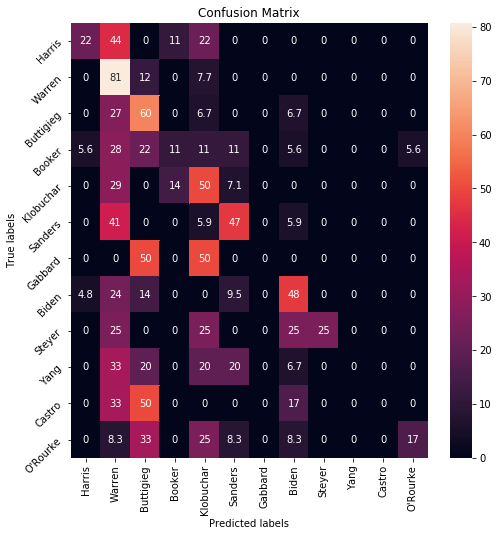

In [52]:
clf_random_forest_v = RandomForestClassifier(n_estimators= 150,  min_samples_leaf = 3)
clf_random_forest_v.fit(X_train, y_train)
y_valid_random_forest = clf_random_forest_v.predict(X_valid)
cm = np.round(confusion_matrix(y_valid, y_valid_random_forest,unique_label, normalize='true'), 4) * 100
fig, ax = plt.subplots(figsize=(8, 8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, ); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(unique_label)
ax.yaxis.set_ticklabels(unique_label)
plt.xticks(rotation=90)
plt.yticks(rotation=45)

##### I chose to use random forest model because random forest is made up of many decision trees, and the tree model I build in the last question didn't performance well on the test data, I want to use random forest to improve the performance. Random forest model doesn't just simply average the prediction of trees, it combines hundreds or thousands of decision trees, trains each one on a slightly different set of the observations, splitting nodes in each tree considering a limited number of the features, So it can fix the overfitting problem in decision tree. That's why I chose random forest in this question. From the accurary score, we can see that random forest performances much better than dicision trees. 
#####  I tune the hyperparameter min_samples_leaf on the valid data because min_samplea_leaf is the end node of a decision tree. A smaller leaf makes the model more prone to capturing noise in train data, so I think min_samples_leaf is a important parameters which can affect the performance of the model. I set a list of values of min_samples_leaf, and I built model with different min_samples_leaf values separately and check the accurary of the training and validation data. 
##### From the plot, we can see that the model performs particularly well on the "Warren" class, the true positive is 77%, but the model performs particularly poorly on "Gabbard" class ,"Steyer" class, "Yang" class and "Castro" class. They are all misclassified. It is pretty clear that although the accurary is improved in random forest model compared to the decision tree model, the misclassification cases are greater in random forest model.

In [53]:
# Apply max_depth = 20 on test data

clf_rf = RandomForestClassifier(n_estimators= 150,  min_samples_leaf = 3)
clf_rf = clf_rf.fit(X_train_all,y_train_all)
y_test_pred_rf = clf_rf.predict(X_test)
print('min_samples_leaf:', 3)
print('Training accuracy:', clf_rf.score(X_train_all, y_train_all))


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


min_samples_leaf: 3
Training accuracy: 0.9450757575757576


## #11
### Compare the performance of three models

##### I evaluated three models by accuracy, whether there is overfitting problem and misclassification cases. Firstly, we can see that from the accuracy scores in the three models, random forest has the highest accuracy on the training data, which is 94.5%, and decision tree model has the lowest accuracy, which is 59.66%, logistic regression model has 85.23% accuracy on training data. But if we look at the misclassification cases, we can find the in the random forest model, there are 8 classes are total misclassified. In logistic regression model, there are only one class are totally misclassified.  If we look at the accuracy on the training and valid data together, it is obvious that the logistic has higher accuracy on the valid data when the accuracy of the training data are almost the same.
##### Combine all these three factors, I think the Logistic regression model performances the best.

## #12
### Generate test labels using logistic regression model

In [54]:
y_test_labels = clf_l.predict(X_test)

In [55]:
# add labels to the test dataset
full_test['pred_label'] = y_test_labels
# save the file
full_test.to_csv('./test_with_pred_labels.csv')

# Part Three
## Semi-supervised learning

## #13
### Model choose

##### In this question, I chose Logistic Regression model to implement semi-supervised learning. Because I want a model that can produce the probabilities for each class, but tree models, including decision tree and random forest I implemented in the last part can only return the predicted class instead of the probabilities of each class. In logistic regression model, the predicted values tell you how likely it is that an observation belongs to a class. So I will use logistic regression model in this part.

## #14
### Interactively adding test data to training data



In [56]:
X_test_features = full_test.drop(['text','pred_label'],axis = 1).copy(deep=True)

In [57]:
# generate the probabilities of each label 
# pick the max value in each observation
full_test['pred_prob'] = np.max(clf_l.predict_proba(X_test_features), axis=1)
# Take top 10% instances
top10_r1 = full_test\
            .sort_values(by='pred_prob', ascending=False)\
            .rename(columns={'pred_label': 'labels'})\
            .head(11)
df_r1 = top10_r1.drop(['pred_prob'],axis = 1)

In [58]:
# Add top10_r1 to the training dataset
train_r1 = pd.DataFrame(
    np.concatenate([df_r1, full_training], axis=0), 
    columns=df_r1.columns
)

In [59]:
#check the shape of train_r1,df_r1 and full_training 
print(train_r1.shape)
print(df_r1.shape)
print(full_training.shape)

(539, 29783)
(11, 29783)
(528, 29783)


### Retrain the model

In [60]:
# split training data into training and validation
from sklearn.model_selection import train_test_split
X_training_r1 = train_r1.drop(['text', 'labels'], axis=1)
X_training_r1, X_valid_r1, y_training_r1, y_valid_r1= train_test_split(
    X_training_r1, train_r1['labels'], test_size=0.3, random_state=0)

In [61]:
# Create a scaler object
sc = StandardScaler()
# Fit the scaler to the training data and transform
X_training_std_r1 = sc.fit_transform(X_training_r1)
# Apply the scaler to the test data
X_valid_std_r1 = sc.transform(X_valid_r1)
C_r1 = [0.05, 1, 10, 50, 640]
for c_r1 in C_r1:
    clf_lr = LogisticRegression(penalty='l1', C=c_r1, solver= 'liblinear' ,max_iter =70, random_state= 13)
    clf_lr.fit(X_training_r1, y_training_r1)
    print('C:', c_r1)
    print('Training accuracy:', clf_lr.score(X_training_std_r1, y_training_r1))
    print('Validation accuracy:', clf_lr.score(X_valid_std_r1, y_valid_r1))

C: 0.05
Training accuracy: 0.20424403183023873
Validation accuracy: 0.2345679012345679
C: 1
Training accuracy: 0.9602122015915119
Validation accuracy: 0.46296296296296297
C: 10
Training accuracy: 0.9681697612732095
Validation accuracy: 0.49382716049382713
C: 50
Training accuracy: 0.986737400530504
Validation accuracy: 0.4691358024691358
C: 640
Training accuracy: 1.0
Validation accuracy: 0.4567901234567901


##### From the results, we can see that when C = 10, the accuracy of validation data is reaches the highest, which is 49.38%, and there is no overfitting on the training data.

In [62]:
X_train_r1 = train_r1.drop(['text', 'labels'],axis = 1)

In [63]:
y_train_r1 = train_r1['labels']

In [64]:
X_train_std_r1 = sc.fit_transform(X_train_r1)

clf_lr_r1 = LogisticRegression(penalty='l1', C=10, solver= 'liblinear' ,max_iter =70, random_state= 23)
clf_lr_r1.fit(X_train_r1, y_train_r1)

print('C:',10)
print('Training accuracy:', clf_lr_r1.score(X_train_std_all, y_train_all))

C: 10
Training accuracy: 0.9810606060606061


##### After i added the top 10% data to the original training data, the best and tuned on the valid data, we can see that when C = 10, the accuracy of validation data reaches the highest which is 49.38%, which is higher than the performance of the model in the part 2. What's more, the accuracy on the whole training data is improved after adding top10 to the traning data. From the results, we can see that the accuracy of the retrained model is 98.1%, higher than the model in part two 85.23%.

## #15
### Repeat the process

#### iteration 2

In [65]:
X_test_features_r2 = X_test_features[~X_test_features.index.isin(df_r1.index)]
np.max(clf_l.predict_proba(X_test_features_r2), axis=1)
top10_r2 = full_test\
            .sort_values(by='pred_prob', ascending=False)\
            .rename(columns={'pred_label': 'labels'})\
            .head(11)
df_r2 = top10_r2.drop(['pred_prob'],axis = 1)
# add top 10%
train_r2 = pd.DataFrame(
    np.concatenate([df_r2, train_r1], axis=0), 
    columns=df_r2.columns)

In [66]:
# check dimension
train_r2.shape

(550, 29783)

In [67]:
X_training_r2 = train_r2.drop(['text', 'labels'], axis=1)
X_training_r2, X_valid_r2, y_training_r2, y_valid_r2= train_test_split(
    X_training_r2, train_r2['labels'], test_size=0.3, random_state=0)

In [68]:
# Create a scaler object
sc = StandardScaler()
# Fit the scaler to the training data and transform
X_training_std_r2 = sc.fit_transform(X_training_r2)
# Apply the scaler to the test data
X_valid_std_r2 = sc.transform(X_valid_r2)
C_r2 = [0.05, 1, 10, 50, 640]
for c_r2 in C_r2:
    clf_lr_2 = LogisticRegression(penalty='l1', C=c_r2, solver= 'liblinear' ,max_iter =70, random_state= 13)
    clf_lr_2.fit(X_training_r2, y_training_r2)
    print('C:', c_r2)
    print('Training accuracy:', clf_lr_2.score(X_training_std_r2, y_training_r2))
    print('Validation accuracy:', clf_lr_2.score(X_valid_std_r2, y_valid_r2))

C: 0.05
Training accuracy: 0.18441558441558442
Validation accuracy: 0.2
C: 1
Training accuracy: 0.974025974025974
Validation accuracy: 0.44242424242424244
C: 10
Training accuracy: 0.987012987012987
Validation accuracy: 0.4303030303030303
C: 50
Training accuracy: 0.9948051948051948
Validation accuracy: 0.44242424242424244
C: 640
Training accuracy: 1.0
Validation accuracy: 0.4666666666666667


##### From the results, we can see that when C = 50 or C = 1, the accuracy of validation data is reaches the highest, which is 44.24%. But we C= 50, the accuracy of training data is higher.


In [69]:
X_train_r2 = train_r2.drop(['text', 'labels'],axis = 1)
y_train_r2 = train_r2['labels']

In [70]:
X_train_std_r2 = sc.fit_transform(X_train_r2)
clf_lr_r2 = LogisticRegression(penalty='l1', C=50, solver= 'liblinear' ,max_iter =70, random_state= 23)
clf_lr_r2.fit(X_train_r2, y_train_r2)

print('C:',50)
print('Training accuracy:', clf_lr_r2.score(X_train_std_all, y_train_all))

C: 50
Training accuracy: 0.9829545454545454


##### After i added the another top 10% data to the original training data, the best and tuned on the valid data, we can see that when C = 50, the accuracy of validation data reaches the highest which is 44.24%, which is higher than the performance of the model in the part 2. What's more, the accuracy on the whole training data is improved after adding top10 to the traning data. From the results, we can see that the accuracy of the retrained model is 98.1%, higher than the model in part two 85.23%, also slightly higher than the previous model 98.1%.


#### Iteration 3

In [71]:
X_test_features_r3 = X_test_features[~X_test_features.index.isin(df_r2.index)]
np.max(clf_l.predict_proba(X_test_features_r3), axis=1)
top10_r3 = full_test\
            .sort_values(by='pred_prob', ascending=False)\
            .rename(columns={'pred_label': 'labels'})\
            .head(11)
df_r3 = top10_r3.drop(['pred_prob'],axis = 1)
# add top 10%
train_r3 = pd.DataFrame(
    np.concatenate([df_r3, train_r2], axis=0), 
    columns=df_r3.columns)

In [72]:
# check dimension
train_r3.shape

(561, 29783)

In [73]:
X_training_r3 = train_r3.drop(['text', 'labels'], axis=1)
X_training_r3, X_valid_r3, y_training_r3, y_valid_r3= train_test_split(
    X_training_r3, train_r3['labels'], test_size=0.3, random_state=0)

In [74]:
# Create a scaler object
sc = StandardScaler()
# Fit the scaler to the training data and transform
X_training_std_r3 = sc.fit_transform(X_training_r3)
# Apply the scaler to the test data
X_valid_std_r3 = sc.transform(X_valid_r3)
C_r3 = [0.05, 1, 10, 50, 640]
for c_r3 in C_r3:
    clf_lr_3 = LogisticRegression(penalty='l1', C=c_r3, solver= 'liblinear' ,max_iter =70, random_state= 13)
    clf_lr_3.fit(X_training_r3, y_training_r3)
    print('C:', c_r3)
    print('Training accuracy:', clf_lr_3.score(X_training_std_r3, y_training_r3))
    print('Validation accuracy:', clf_lr_3.score(X_valid_std_r3, y_valid_r3))

C: 0.05
Training accuracy: 0.19387755102040816
Validation accuracy: 0.17751479289940827
C: 1
Training accuracy: 0.9744897959183674
Validation accuracy: 0.41420118343195267
C: 10
Training accuracy: 0.9948979591836735
Validation accuracy: 0.378698224852071
C: 50
Training accuracy: 0.9974489795918368
Validation accuracy: 0.40828402366863903
C: 640
Training accuracy: 1.0
Validation accuracy: 0.4378698224852071


##### We can see that the performance of model on both training and  test deceases compared to the last model. But I still chose the highest accuracy C value, which is C = 1.

In [75]:
X_train_r3 = train_r3.drop(['text', 'labels'],axis = 1)
y_train_r3 = train_r3['labels']

In [76]:
X_train_std_r3 = sc.fit_transform(X_train_r3)
clf_lr_r3 = LogisticRegression(penalty='l1', C=1, solver= 'liblinear' ,max_iter =70, random_state= 23)
clf_lr_r3.fit(X_train_r3, y_train_r3)

print('C:',1)
print('Training accuracy:', clf_lr_r3.score(X_train_std_all, y_train_all))

C: 1
Training accuracy: 0.9621212121212122


##### Clearly, After i added the another top 10% data to the original training data in this step, the best and tuned on the valid data, we can see that when C = 1, the accuracy of validation data reaches the highest which is 41.42%, which is lower than the performance of the model in the part 2. What's more, the accuracy on the whole training data decreases after adding top10 to the traning data. From the results, we can see that the accuracy of the retrained model is 96,21%, higher than the model in part two 85.23%, but lower than the previous two models. The overall performance of the model decreases.

#### Iteration 4

In [77]:
X_test_features_r4 = X_test_features[~X_test_features.index.isin(df_r3.index)]
np.max(clf_l.predict_proba(X_test_features_r4), axis=1)
top10_r4 = full_test\
            .sort_values(by='pred_prob', ascending=False)\
            .rename(columns={'pred_label': 'labels'})\
            .head(11)
df_r4 = top10_r4.drop(['pred_prob'],axis = 1)
# add top 10%
train_r4 = pd.DataFrame(
    np.concatenate([df_r4, train_r3], axis=0), 
    columns=df_r4.columns)

In [78]:
# check dimension
train_r4.shape

(572, 29783)

In [79]:
X_training_r4 = train_r4.drop(['text', 'labels'], axis=1)
X_training_r4, X_valid_r4, y_training_r4, y_valid_r4= train_test_split(
    X_training_r4, train_r4['labels'], test_size=0.3, random_state=0)

In [80]:
# Create a scaler object
sc = StandardScaler()
# Fit the scaler to the training data and transform
X_training_std_r4 = sc.fit_transform(X_training_r4)
# Apply the scaler to the test data
X_valid_std_r4 = sc.transform(X_valid_r4)
C_r4 = [0.05, 1, 10, 50, 640]
for c_r4 in C_r4:
    clf_lr_4 = LogisticRegression(penalty='l1', C=c_r4, solver= 'liblinear' ,max_iter =70, random_state= 13)
    clf_lr_4.fit(X_training_r4, y_training_r4)
    print('C:', c_r4)
    print('Training accuracy:', clf_lr_4.score(X_training_std_r4, y_training_r4))
    print('Validation accuracy:', clf_lr_4.score(X_valid_std_r4, y_valid_r4))

C: 0.05
Training accuracy: 0.2525
Validation accuracy: 0.2616279069767442
C: 1
Training accuracy: 0.9775
Validation accuracy: 0.47093023255813954
C: 10
Training accuracy: 0.985
Validation accuracy: 0.43023255813953487
C: 50
Training accuracy: 0.99
Validation accuracy: 0.46511627906976744
C: 640
Training accuracy: 1.0
Validation accuracy: 0.5058139534883721


In [81]:
X_train_r4 = train_r4.drop(['text', 'labels'],axis = 1)
y_train_r4 = train_r4['labels']

In [82]:
X_train_std_r4 = sc.fit_transform(X_train_r4)
clf_lr_r4 = LogisticRegression(penalty='l1', C=1, solver= 'liblinear' ,max_iter =70, random_state= 23)
clf_lr_r4.fit(X_train_r4, y_train_r4)

print('C:',1)
print('Training accuracy:', clf_lr_r4.score(X_train_std_all, y_train_all))


C: 1
Training accuracy: 0.9621212121212122


##### The performance stays the same as the previous model

#### Interation 5

In [83]:
X_test_features_r5 = X_test_features[~X_test_features.index.isin(df_r4.index)]
np.max(clf_l.predict_proba(X_test_features_r5), axis=1)
top10_r5 = full_test\
            .sort_values(by='pred_prob', ascending=False)\
            .rename(columns={'pred_label': 'labels'})\
            .head(11)
df_r5 = top10_r5.drop(['pred_prob'],axis = 1)
# add top 10%
train_r5 = pd.DataFrame(
    np.concatenate([df_r5, train_r4], axis=0), 
    columns=df_r5.columns)

In [84]:
# check dimension
train_r5.shape

(583, 29783)

In [85]:
X_training_r5 = train_r5.drop(['text', 'labels'], axis=1)
X_training_r5, X_valid_r5, y_training_r5, y_valid_r5= train_test_split(
    X_training_r5, train_r5['labels'], test_size=0.3, random_state=0)

In [86]:
# Create a scaler object
sc = StandardScaler()
# Fit the scaler to the training data and transform
X_training_std_r5 = sc.fit_transform(X_training_r5)
# Apply the scaler to the test data
X_valid_std_r5 = sc.transform(X_valid_r5)
C_r5 = [0.05, 1, 10, 50, 640]
for c_r5 in C_r5:
    clf_lr_5 = LogisticRegression(penalty='l1', C=c_r5, solver= 'liblinear' ,max_iter =70, random_state= 13)
    clf_lr_5.fit(X_training_r5, y_training_r5)
    print('C:', c_r5)
    print('Training accuracy:', clf_lr_5.score(X_training_std_r5, y_training_r5))
    print('Validation accuracy:', clf_lr_5.score(X_valid_std_r5, y_valid_r5))

C: 0.05
Training accuracy: 0.2426470588235294
Validation accuracy: 0.24571428571428572
C: 1
Training accuracy: 0.9828431372549019
Validation accuracy: 0.4742857142857143
C: 10
Training accuracy: 0.9901960784313726
Validation accuracy: 0.45714285714285713
C: 50
Training accuracy: 0.9901960784313726
Validation accuracy: 0.4857142857142857
C: 640
Training accuracy: 1.0
Validation accuracy: 0.49142857142857144


In [87]:
X_train_r5 = train_r5.drop(['text', 'labels'],axis = 1)
y_train_r5 = train_r5['labels']

In [88]:
X_train_std_r5 = sc.fit_transform(X_train_r5)
clf_lr_r5 = LogisticRegression(penalty='l1', C=50, solver= 'liblinear' ,max_iter =70, random_state= 23)
clf_lr_r5.fit(X_train_r5, y_train_r5)

print('C:',50)
print('Training accuracy:', clf_lr_r5.score(X_train_std_all, y_train_all))

C: 50
Training accuracy: 0.9848484848484849


#### Iteration 6

In [89]:
X_test_features_r6 = X_test_features[~X_test_features.index.isin(df_r5.index)]
np.max(clf_l.predict_proba(X_test_features_r6), axis=1)
top10_r6 = full_test\
            .sort_values(by='pred_prob', ascending=False)\
            .rename(columns={'pred_label': 'labels'})\
            .head(11)
df_r6 = top10_r6.drop(['pred_prob'],axis = 1)
# add top 10%
train_r6 = pd.DataFrame(
    np.concatenate([df_r6, train_r5], axis=0), 
    columns=df_r6.columns)

In [90]:
# check dimension
train_r6.shape

(594, 29783)

In [91]:
X_training_r6 = train_r6.drop(['text', 'labels'], axis=1)
X_training_r6, X_valid_r6, y_training_r6, y_valid_r6= train_test_split(
    X_training_r6, train_r6['labels'], test_size=0.3, random_state=0)

In [92]:
# Create a scaler object
sc = StandardScaler()
# Fit the scaler to the training data and transform
X_training_std_r6 = sc.fit_transform(X_training_r6)
# Apply the scaler to the test data
X_valid_std_r6 = sc.transform(X_valid_r6)
C_r6 = [0.05, 1, 10, 50, 640]
for c_r6 in C_r6:
    clf_lr_r6 = LogisticRegression(penalty='l1', C=c_r6, solver= 'liblinear' ,max_iter =70, random_state= 13)
    clf_lr_r6.fit(X_training_r6, y_training_r6)
    print('C:', c_r6)
    print('Training accuracy:', clf_lr_r6.score(X_training_std_r6, y_training_r6))
    print('Validation accuracy:', clf_lr_r6.score(X_valid_std_r6, y_valid_r6))

C: 0.05
Training accuracy: 0.21204819277108433
Validation accuracy: 0.24581005586592178
C: 1
Training accuracy: 0.9662650602409638
Validation accuracy: 0.4301675977653631
C: 10
Training accuracy: 0.9879518072289156
Validation accuracy: 0.441340782122905
C: 50
Training accuracy: 0.9951807228915662
Validation accuracy: 0.45251396648044695
C: 640
Training accuracy: 1.0
Validation accuracy: 0.4748603351955307


In [93]:
X_train_r6 = train_r6.drop(['text', 'labels'],axis = 1)
y_train_r6 = train_r6['labels']

In [94]:
X_train_std_r6 = sc.fit_transform(X_train_r6)
clf_lr_r6 = LogisticRegression(penalty='l1', C=50, solver= 'liblinear' ,max_iter =70, random_state= 23)
clf_lr_r6.fit(X_train_r6, y_train_r6)

print('C:',50)
print('Training accuracy:', clf_lr_r6.score(X_train_std_all, y_train_all))

C: 50
Training accuracy: 0.9810606060606061


##### We can notice that the performance stays stable.

#### Iteration 7

In [95]:
X_test_features_r7 = X_test_features[~X_test_features.index.isin(df_r6.index)]
np.max(clf_l.predict_proba(X_test_features_r7), axis=1)
top10_r7 = full_test\
            .sort_values(by='pred_prob', ascending=False)\
            .rename(columns={'pred_label': 'labels'})\
            .head(11)
df_r7 = top10_r7.drop(['pred_prob'],axis = 1)
# add top 10%
train_r7 = pd.DataFrame(
    np.concatenate([df_r7, train_r6], axis=0), 
    columns=df_r7.columns)

In [96]:
# check dimension
train_r7.shape

(605, 29783)

In [97]:
X_training_r7 = train_r7.drop(['text', 'labels'], axis=1)
X_training_r7, X_valid_r7, y_training_r7, y_valid_r7= train_test_split(
    X_training_r7, train_r7['labels'], test_size=0.3, random_state=0)

In [98]:
# Create a scaler object
sc = StandardScaler()
# Fit the scaler to the training data and transform
X_training_std_r7 = sc.fit_transform(X_training_r7)
# Apply the scaler to the test data
X_valid_std_r7 = sc.transform(X_valid_r7)
C_r7 = [0.05, 1, 10, 50, 640]
for c_r7 in C_r7:
    clf_lr_r7 = LogisticRegression(penalty='l1', C=c_r7, solver= 'liblinear' ,max_iter =70, random_state= 13)
    clf_lr_r7.fit(X_training_r7, y_training_r7)
    print('C:', c_r7)
    print('Training accuracy:', clf_lr_r7.score(X_training_std_r7, y_training_r7))
    print('Validation accuracy:', clf_lr_r7.score(X_valid_std_r7, y_valid_r7))

C: 0.05
Training accuracy: 0.27423167848699764
Validation accuracy: 0.23626373626373626
C: 1
Training accuracy: 0.9716312056737588
Validation accuracy: 0.46703296703296704
C: 10
Training accuracy: 0.9952718676122931
Validation accuracy: 0.46703296703296704
C: 50
Training accuracy: 0.9952718676122931
Validation accuracy: 0.46703296703296704
C: 640
Training accuracy: 1.0
Validation accuracy: 0.46703296703296704


In [99]:
X_train_r7 = train_r7.drop(['text', 'labels'],axis = 1)
y_train_r7 = train_r7['labels']

In [100]:
X_train_std_r7 = sc.fit_transform(X_train_r7)
clf_lr_r7 = LogisticRegression(penalty='l1', C=10, solver= 'liblinear' ,max_iter =70, random_state= 23)
clf_lr_r7.fit(X_train_r7, y_train_r7)

print('C:',10)
print('Training accuracy:', clf_lr_r7.score(X_train_std_all, y_train_all))

C: 10
Training accuracy: 0.9810606060606061


#### Iteration 8

In [101]:
X_test_features_r8 = X_test_features[~X_test_features.index.isin(df_r7.index)]
np.max(clf_l.predict_proba(X_test_features_r8), axis=1)
top10_r8 = full_test\
            .sort_values(by='pred_prob', ascending=False)\
            .rename(columns={'pred_label': 'labels'})\
            .head(11)
df_r8 = top10_r8.drop(['pred_prob'],axis = 1)
# add top 10%
train_r8 = pd.DataFrame(
    np.concatenate([df_r8, train_r7], axis=0), 
    columns=df_r8.columns)

In [102]:
# check dimension
train_r8.shape

(616, 29783)

In [103]:
X_training_r8 = train_r8.drop(['text', 'labels'], axis=1)
X_training_r8, X_valid_r8, y_training_r8, y_valid_r8= train_test_split(
    X_training_r8, train_r8['labels'], test_size=0.3, random_state=0)

In [104]:
# Create a scaler object
sc = StandardScaler()
# Fit the scaler to the training data and transform
X_training_std_r8 = sc.fit_transform(X_training_r8)
# Apply the scaler to the test data
X_valid_std_r8 = sc.transform(X_valid_r8)
C_r8 = [0.05, 1, 10, 50, 640]
for c_r8 in C_r8:
    clf_lr_r8 = LogisticRegression(penalty='l1', C=c_r8, solver= 'liblinear' ,max_iter =70, random_state= 13)
    clf_lr_r8.fit(X_training_r8, y_training_r8)
    print('C:', c_r8)
    print('Training accuracy:', clf_lr_r8.score(X_training_std_r8, y_training_r8))
    print('Validation accuracy:', clf_lr_r8.score(X_valid_std_r8, y_valid_r8))

C: 0.05
Training accuracy: 0.28074245939675174
Validation accuracy: 0.2702702702702703
C: 1
Training accuracy: 0.9721577726218097
Validation accuracy: 0.5513513513513514
C: 10
Training accuracy: 0.9837587006960556
Validation accuracy: 0.5567567567567567
C: 50
Training accuracy: 0.9953596287703016
Validation accuracy: 0.572972972972973
C: 640
Training accuracy: 1.0
Validation accuracy: 0.5621621621621622


In [105]:
X_train_r8 = train_r8.drop(['text', 'labels'],axis = 1)
y_train_r8 = train_r8['labels']

In [106]:
X_train_std_r8 = sc.fit_transform(X_train_r8)
clf_lr_r8 = LogisticRegression(penalty='l1', C=50, solver= 'liblinear' ,max_iter =70, random_state= 23)
clf_lr_r8.fit(X_train_r8, y_train_r8)

print('C:',50)
print('Training accuracy:', clf_lr_r8.score(X_train_std_all, y_train_all))

C: 50
Training accuracy: 0.9848484848484849


#### Iteration 9

In [107]:
X_test_features_r9 = X_test_features[~X_test_features.index.isin(df_r8.index)]
np.max(clf_l.predict_proba(X_test_features_r9), axis=1)
top10_r9 = full_test\
            .sort_values(by='pred_prob', ascending=False)\
            .rename(columns={'pred_label': 'labels'})\
            .head(11)
df_r9 = top10_r9.drop(['pred_prob'],axis = 1)
# add top 10%
train_r9 = pd.DataFrame(
    np.concatenate([df_r9, train_r8], axis=0), 
    columns=df_r9.columns)

In [108]:
# check dimension
train_r9.shape

(627, 29783)

In [109]:
X_training_r9 = train_r9.drop(['text', 'labels'], axis=1)
X_training_r9, X_valid_r9, y_training_r9, y_valid_r9= train_test_split(
    X_training_r9, train_r9['labels'], test_size=0.3, random_state=0)

In [110]:
# Create a scaler object
sc = StandardScaler()
# Fit the scaler to the training data and transform
X_training_std_r9 = sc.fit_transform(X_training_r9)
# Apply the scaler to the test data
X_valid_std_r9 = sc.transform(X_valid_r9)
C_r9 = [0.05, 1, 10, 50, 640]
for c_r9 in C_r9:
    clf_lr_r9 = LogisticRegression(penalty='l1', C=c_r9, solver= 'liblinear' ,max_iter =70, random_state= 13)
    clf_lr_r9.fit(X_training_r9, y_training_r9)
    print('C:', c_r9)
    print('Training accuracy:', clf_lr_r9.score(X_training_std_r9, y_training_r9))
    print('Validation accuracy:', clf_lr_r9.score(X_valid_std_r9, y_valid_r9))

C: 0.05
Training accuracy: 0.2853881278538813
Validation accuracy: 0.2804232804232804
C: 1
Training accuracy: 0.9680365296803652
Validation accuracy: 0.48677248677248675
C: 10
Training accuracy: 0.9794520547945206
Validation accuracy: 0.48677248677248675
C: 50
Training accuracy: 0.9794520547945206
Validation accuracy: 0.48148148148148145
C: 640
Training accuracy: 1.0
Validation accuracy: 0.5343915343915344


In [111]:
X_train_r9 = train_r9.drop(['text', 'labels'],axis = 1)
y_train_r9 = train_r9['labels']

In [112]:
X_train_std_r9 = sc.fit_transform(X_train_r9)
clf_lr_r9 = LogisticRegression(penalty='l1', C=50, solver= 'liblinear' ,max_iter =70, random_state= 23)
clf_lr_r9.fit(X_train_r9, y_train_r9)

print('C:',50)
print('Training accuracy:', clf_lr_r9.score(X_train_std_all, y_train_all))

C: 50
Training accuracy: 0.9829545454545454


#### Iteration 10

In [113]:
X_test_features_r10 = X_test_features[~X_test_features.index.isin(df_r9.index)]
np.max(clf_l.predict_proba(X_test_features_r10), axis=1)
top10_r10 = full_test\
            .sort_values(by='pred_prob', ascending=False)\
            .rename(columns={'pred_label': 'labels'})\
            .head(11)
df_r10 = top10_r10.drop(['pred_prob'],axis = 1)
# add top 10%
train_r10 = pd.DataFrame(
    np.concatenate([df_r10, train_r9], axis=0), 
    columns=df_r10.columns)

In [114]:
# check dimension
train_r10.shape

(638, 29783)

In [115]:
X_training_r10 = train_r10.drop(['text', 'labels'], axis=1)
X_training_r10, X_valid_r10, y_training_r10, y_valid_r10= train_test_split(
    X_training_r10, train_r10['labels'], test_size=0.3, random_state=0)

In [116]:
# Create a scaler object
sc = StandardScaler()
# Fit the scaler to the training data and transform
X_training_std_r10 = sc.fit_transform(X_training_r10)
# Apply the scaler to the test data
X_valid_std_r10 = sc.transform(X_valid_r10)
C_r10 = [0.05, 1, 10, 50, 640]
for c_r10 in C_r10:
    clf_lr_r10 = LogisticRegression(penalty='l1', C=c_r10, solver= 'liblinear' ,max_iter =70, random_state= 13)
    clf_lr_r10.fit(X_training_r10, y_training_r10)
    print('C:', c_r10)
    print('Training accuracy:', clf_lr_r10.score(X_training_std_r10, y_training_r10))
    print('Validation accuracy:', clf_lr_r10.score(X_valid_std_r10, y_valid_r10))

C: 0.05
Training accuracy: 0.31614349775784756
Validation accuracy: 0.328125
C: 1
Training accuracy: 0.9618834080717489
Validation accuracy: 0.5208333333333334
C: 10
Training accuracy: 0.9865470852017937
Validation accuracy: 0.5052083333333334
C: 50
Training accuracy: 0.9887892376681614
Validation accuracy: 0.5416666666666666
C: 640
Training accuracy: 0.9977578475336323
Validation accuracy: 0.5885416666666666


In [117]:
X_train_r10 = train_r10.drop(['text', 'labels'],axis = 1)
y_train_r10 = train_r10['labels']

In [118]:
X_train_std_r10 = sc.fit_transform(X_train_r10)
clf_lr_r10 = LogisticRegression(penalty='l1', C=50, solver= 'liblinear' ,max_iter =70, random_state= 23)
clf_lr_r10.fit(X_train_r10, y_train_r10)

print('C:',50)
print('Training accuracy:', clf_lr_r10.score(X_train_std_all, y_train_all))

C: 50
Training accuracy: 0.9829545454545454


#### plot the results

In [119]:
x_lists = [0,10,20,30,40,50,60,70,80,90,100]
accuracy_lists = [0.8522727272727273,0.9810606060606061,0.9829545454545454,0.9621212121212122, 0.9621212121212122
                 ,0.9848484848484849,0.9810606060606061,0.9810606060606061, 0.9848484848484849
                 ,0.9829545454545454,0.9829545454545454]


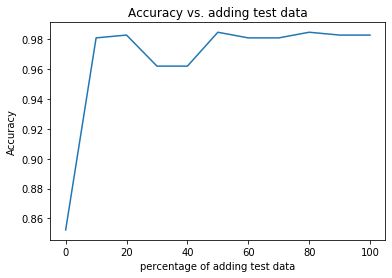

In [120]:
# importing the required module 
import matplotlib.pyplot as plt 
  
# x axis values 
x = x_lists
# corresponding y axis values 
y = accuracy_lists 
  
# plotting the points  
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('percentage of adding test data') 
# naming the y axis 
plt.ylabel('Accuracy') 
  
# giving a title to my graph 
plt.title('Accuracy vs. adding test data') 
  
# function to show the plot 
plt.show()

##### From the plot, we can see that there is a sharp increase when adding first top 10% of test data, then the trend of graph stays stable. So I think we can't say that the more data we add to the training data, the higher the performance.  It also shows that semi_supervised doesn't guarantee the performance increase.

## #16

In [121]:
y_test_pred_final = clf_lr_r10.predict(X_test)

In [122]:
col_1 = [f'test_{i+1}.txt' for i in range(111)]
col_2 = y_test_labels
col_3 = y_test_pred_final

In [123]:
df_txt = pd.DataFrame({'filename':col_1, 'label_1':col_2, 'label_2': col_3})

In [124]:
#SAVE THE FILE
df_txt.to_csv('/Users/chensong/UW/2020spring/575B/Problem_set/problemset3/test_labels.txt',header=True, index=False, sep='\t', mode='a')



